In [32]:
%matplotlib inline
import matplotlib.pyplot as plt

import IPython.display as ipd

import numpy as np
import scipy
import librosa

import librosa.display
from scipy import signal
from pydub import AudioSegment

from pydub.playback import play

import numpy as np

from scipy.io import wavfile

# 오디오 불러오기

In [33]:
path = '/Users/apple/Desktop/test/test/audio/clip_0a0a60a16.wav'

In [3]:
y, sr = librosa.load(path,sr = 16000)

In [4]:
print(sr)
print(type(y))

16000
<class 'numpy.ndarray'>


In [5]:
y

array([-0.00018311,  0.        ,  0.00018311, ...,  0.00027466,
        0.00039673,  0.00027466], dtype=float32)

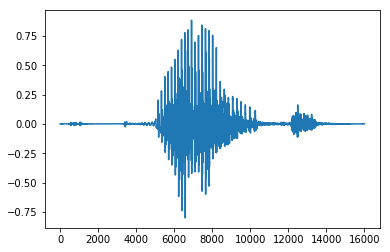

In [6]:
plt.plot(y)

In [7]:
ipd.Audio(y,rate = sr)

In [8]:
y3 = AudioSegment.from_file(path)

In [9]:
type(y3)

pydub.audio_segment.AudioSegment

In [10]:
y3

In [11]:
sr4, y4 = wavfile.read(path)

In [12]:
print(sr4)
print(type(y4))

16000
<class 'numpy.ndarray'>


In [13]:
ipd.Audio(y4,rate = sr4)

In [138]:
def AudioSegment2librosa(y):
    samples = y.get_array_of_samples()
    samples = np.array(samples)
    samples = audio_regul(samples) #음성 사이즈는 살짝 이상해져서 정규화 필요
    return samples

In [139]:
def librosa2AudioSegment(y, sr = 44100):
    samples = AudioSegment(y.tobytes(), frame_rate=sr, sample_width=y.dtype.itemsize, channels=1)
    return samples

# spectrogram

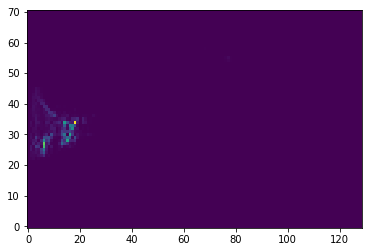

In [14]:
frequencies, times, spectrogram = signal.spectrogram(y, sr)
plt.imshow(spectrogram.T,aspect='auto',origin='lower')
#plt.imshow(np.log(spectrogram.T.astype(np.float32) + 1e-10).T,aspect='auto',origin='lower')

In [15]:
def log_specgram(audio, sample_rate, window_size=20,
                 step_size=10, eps=1e-10):
    nperseg = int(round(window_size * sample_rate / 1e3))
    noverlap = int(round(step_size * sample_rate / 1e3))
    freqs, times, spec = signal.spectrogram(audio,
                                    fs=sample_rate,
                                    window='hann',
                                    nperseg=nperseg,
                                    noverlap=noverlap,
                                    detrend=False)
    return freqs, times, np.log(spec.T.astype(np.float32) + eps)

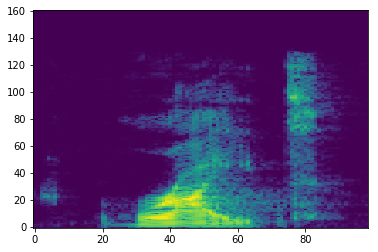

In [16]:
frequencies, times, spectrogram = log_specgram(y, sr)
plt.imshow(spectrogram.T,aspect='auto',origin='lower')

# MFCC

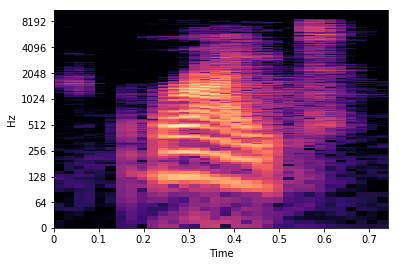

In [17]:
D = librosa.stft(y)
log_power = librosa.logamplitude(D**2, ref_power= np.max)

librosa.display.specshow(log_power, x_axis='time', y_axis="log")

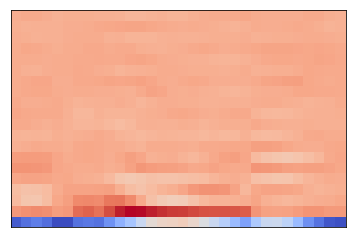

In [18]:
MFCC = librosa.feature.mfcc(y=y, sr=sr)
librosa.display.specshow(MFCC)

# 데이터 처리

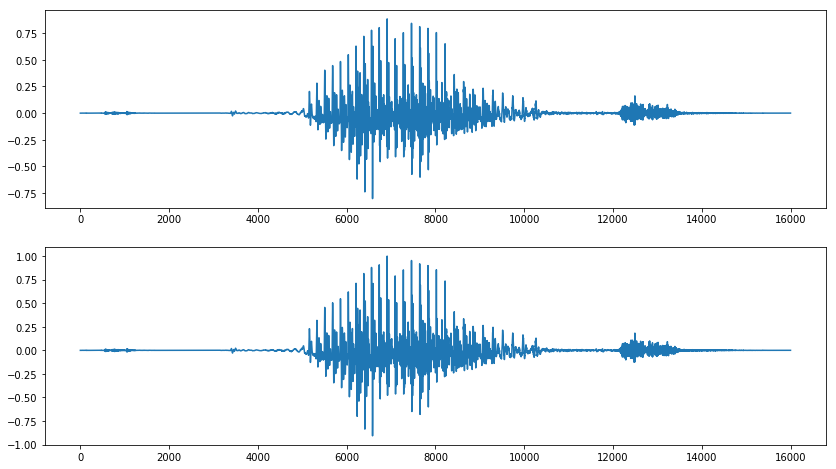

In [19]:
# 진폭 정규화

samples = librosa.util.normalize(y)

fig = plt.figure(figsize=(14, 8))

ax1 = fig.add_subplot(211)
ax1.plot(y)

ax2 = fig.add_subplot(212)
ax2.plot(samples)

In [20]:
# pitch, speed 

def pitchUp(y, sr = 44100, n_step = 10):
    y_pitch_higher = librosa.effects.pitch_shift(y, sr, n_steps=n_step)
    return y_pitch_higher


def pitchDown(y, sr = 44100, n_step = -10):
    y_pitch_lower = librosa.effects.pitch_shift(y, sr, n_steps=n_step)
    return y_pitch_lower

def speedUp(y, n_step=2):
    y_D = librosa.stft(y)
    y_D_fast = librosa.phase_vocoder(y_D, n_step)
    y_faster = librosa.istft(y_D_fast)
    return y_faster


def speedDown(y, n_step=0.5):
    y_D = librosa.stft(y)
    y_D_slow = librosa.phase_vocoder(y_D, n_step)
    y_slower = librosa.istft(y_D_slow)
    return y_slower

In [21]:
ipd.Audio(y,rate = sr)

In [22]:
pitchup = pitchUp(y,sr)
ipd.Audio(pitchup, rate = sr)

In [23]:
pitchdown = pitchDown(y,sr)
ipd.Audio(pitchdown, rate = sr)

In [24]:
speedup = speedUp(y)
ipd.Audio(speedup, rate = sr)

In [25]:
speeddown = speedDown(y)
ipd.Audio(speeddown, rate = sr)

In [34]:
# 볼륨조절

song = AudioSegment.from_mp3(path)

louder_song = song + 20

quieter_song = song - 20

In [35]:
#Play song

play(song)

In [36]:
play(louder_song)

In [37]:
play(quieter_song)

In [ ]:
#save louder song 
louder_song.export("louder_song.mp3", format='mp3')

In [38]:
# 노이즈 추가

def noise_systhesis_path(audio_path, noise_path):    
    audio = AudioSegment.from_file(audio_path)    
    noise = AudioSegment.from_file(noise_path)    
    combine = audio.overlay(noise)    
    return combine


combine = noise_systhesis_path(path, "/Users/apple/Desktop/train/train/audio/_background_noise_/doing_the_dishes.wav")
play(combine)

# modeling  
VGG16

In [7]:
from keras.models import Sequential
from keras.layers.core import Flatten, Dense, Dropout
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.optimizers import SGD

Using TensorFlow backend.


In [8]:
def VGG_16(weights_path=None):
    model = Sequential()
    model.add(ZeroPadding2D((1,1),input_shape=(224,224,3)))
    model.add(Convolution2D(64, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(64, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(Flatten())
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1000, activation='relu'))
    model.add(Dense(30, activation='softmax'))

    #model.summary()
    
    if weights_path:
        model.load_weights(weights_path)

    return model

# High resolution spectrogram

In [43]:
import numpy as np
import librosa.display
import tensorflow as tf
import tensorflow.contrib.eager as tfe

tfe.enable_eager_execution()

/Users/apple/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [44]:
def hz_to_mel(freq):
    return 1127. * tf.log(1.0 + (freq / 700.))

def mel_to_hz(mel):
    return 700.*(tf.exp(mel/1127.)-1.)

def multi_ffts_to_mel(freq_array, n_mels=128):
    melfreq_array = tf.expand_dims(hz_to_mel(freq_array),0)
  
    mel_edges = tf.lin_space(hz_to_mel(tf.reduce_min(freq_array)), #or just use 0
                           hz_to_mel(tf.reduce_max(freq_array)), #or SR/2
                           n_mels+2)
  
    lower_edge_mel, center_mel, upper_edge_mel =tf.split(tf.contrib.signal.frame(mel_edges, 3, 1, axis=-1), 3, axis=-1)

    wt_down = (melfreq_array - lower_edge_mel) / (center_mel - lower_edge_mel)
    wt_up = (upper_edge_mel - melfreq_array) / (upper_edge_mel - center_mel)
  
    mel_weights_matrix = tf.maximum(0.0, tf.minimum(wt_down, wt_up))
    center_mel_freqs = mel_to_hz(center_mel) 
  
    return mel_weights_matrix, center_mel_freqs

def audioframes2logmelspec(b_framed_signal, n_ffts=5, wvls_per_window_hinge=16, n_mel=128, fft_l1=1024, sr=16000):
  # batch_framed_signal has shape: (batch_size x n_windows x fft_l1)
  # decrease weights for samples w/ more than wvls_per_window_hinge
  # wvls_per_window_hinge method could be improved, maybe weight~pmf of poisson?
    
    fft1_space = tf.lin_space(0., .5, 1+fft_l1//2)[1:]
    freq_list =[sr*fft1_space] 
    n_wv_list =[fft_l1*fft1_space]

    fft_list =[tf.spectral.rfft(b_framed_signal)[:,:,1:]]
  
    for i in range(1,n_ffts):
        fft_lnew = fft_l1//2**i
        fftnew_space = tf.lin_space(0., .5, 1+fft_lnew//2)[1:]
    
        freq_list.append(sr*fftnew_space)
        n_wv_list.append(fft_lnew*fftnew_space)
    
        frames_new = b_framed_signal[:, :, (fft_l1-fft_lnew)//2:(fft_l1-fft_lnew)//2+fft_lnew]
        fft_list.append(tf.spectral.rfft(frames_new)[:,:,1:])
    
  
    freq_concat = tf.concat(freq_list, axis=-1)
    n_wv_concat = tf.concat(n_wv_list, axis=-1)
    fft_concat = tf.concat(fft_list, axis=-1)
    
    magnitude_spectros = tf.abs(fft_concat)

    mel_wts, center_mel_freqs = multi_ffts_to_mel(freq_concat, n_mel)
    wvls_wts = tf.where(n_wv_concat>wvls_per_window_hinge, wvls_per_window_hinge/n_wv_concat, tf.ones_like(n_wv_concat))
  
    mel_spectro=tf.tensordot(magnitude_spectros, (mel_wts*tf.expand_dims(wvls_wts,0)),axes = [[2], [1]])

    log_mel_spectro = tf.log(mel_spectro+1e-7)
  
    return tf.expand_dims(log_mel_spectro, -1), center_mel_freqs

In [49]:
some_paths = [
'/Users/apple/Desktop/train/train/audio/marvin/8625475c_nohash_0.wav',
'/Users/apple/Desktop/train/train/audio/tree/8625475c_nohash_1.wav',  
'/Users/apple/Desktop/train/train/audio/tree/8625475c_nohash_2.wav',   
'/Users/apple/Desktop/train/train/audio/tree/8625475c_nohash_3.wav',
'/Users/apple/Desktop/train/train/audio/no/8625475c_nohash_0.wav', 
'/Users/apple/Desktop/train/train/audio/zero/8625475c_nohash_0.wav',
'/Users/apple/Desktop/train/train/audio/zero/8625475c_nohash_1.wav',
'/Users/apple/Desktop/train/train/audio/down/8625475c_nohash_0.wav']

In [47]:
def plot_several_logmelspec(paths):
    n=len(paths)

    plt.figure(figsize=(12,4*n))

    for i, path in enumerate(paths):
        plt.subplot(n, 1, i+1)

        sr, wav = wavfile.read(path)
        signal = wav.astype(np.float32) / np.iinfo(np.int16).max

        b_signals = tf.expand_dims(signal, axis=0)

        b_framed_signal = tf.contrib.signal.frame(b_signals, 
                                          frame_length=1024, 
                                          frame_step = 32)
        log_mel_spectro, center_mel_freqs = audioframes2logmelspec(b_framed_signal, sr=sr)

        librosa.display.specshow(log_mel_spectro[0,:,:,0].numpy().T, sr=sr, x_axis='time', 
                             y_axis='mel', hop_length=32, 
                             fmin=tf.reduce_min(center_mel_freqs), 
                             fmax=tf.reduce_max(center_mel_freqs), 
                             cmap='coolwarm')

        plt.title(path)
        plt.colorbar(format='%+02.0f dB')

    plt.tight_layout()

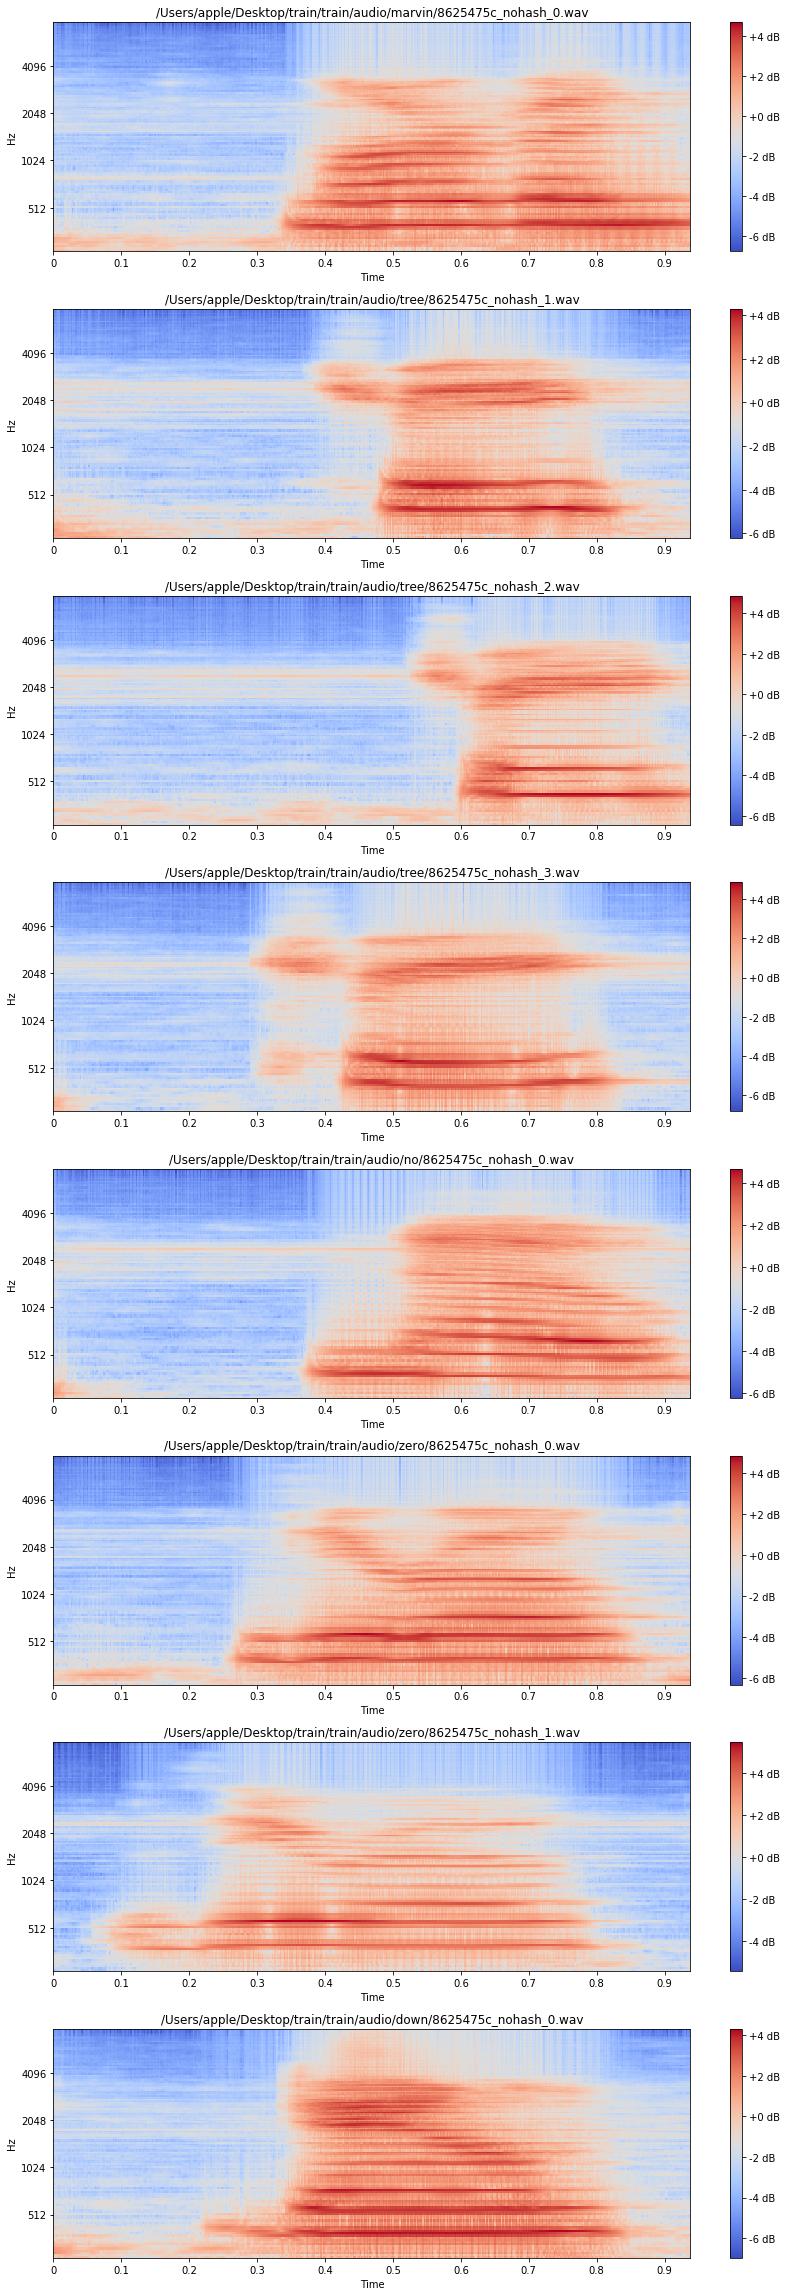

In [50]:
plot_several_logmelspec(some_paths)